In [1]:
%load_ext autoreload
%autoreload 2

# Data Preparation

In [2]:
# Data Preparation
import pandas as pd

all_players_df = pd.read_csv("data/all_players.csv")
all_games_df = pd.read_csv("data/all_games.csv",encoding="utf-8")
all_games_df.dropna(inplace=True)
columns = ["FG_PCT", "FG3_PCT", "FTM", "OREB", "DREB", "REB", "AST"]
string_columns = ["GAME_DATE", "GAME_ID"]
columns_a = [column + "_A" for column in columns]
columns_b = [column + "_B" for column in columns]
games_df = all_games_df[string_columns + columns_a + columns_b]
all_players_df.drop(
    columns=[
        "HomeTeamPlayer1_PLAYER_NAME",
        "HomeTeamPlayer2_PLAYER_NAME",
        "HomeTeamPlayer3_PLAYER_NAME",
        "HomeTeamPlayer4_PLAYER_NAME",
        "HomeTeamPlayer5_PLAYER_NAME",
        "HomeTeamPlayer6_PLAYER_NAME",
    ], inplace=True
)
all_players_df.drop(
    columns=[
        "AwayTeamPlayer1_PLAYER_NAME",
        "AwayTeamPlayer2_PLAYER_NAME",
        "AwayTeamPlayer3_PLAYER_NAME",
        "AwayTeamPlayer4_PLAYER_NAME",
        "AwayTeamPlayer5_PLAYER_NAME",
        "AwayTeamPlayer6_PLAYER_NAME",
    ],
    inplace=True,
)
## Gets Necessary Columns
columns = list(all_players_df.columns)
home_1 = columns.index("TEAM_ID_home")
home_2 = columns.index("TEAM_ID_away")
away_1 = columns.index("TEAM_ID_away")
home_columns = columns[home_1:home_2]
away_columns = columns[away_1:]
## Merges Last N Game Averages with Data on All Games
from api_helpers.game_stats_helpers import load_player_n_games

# gets the last n games for players
players_n_df = load_player_n_games(
    players_df=all_players_df, home_columns=home_columns, away_columns=away_columns, n=5
)

# merges data on the player's average for the past n games with all games
merged_data = pd.merge(
    players_n_df, games_df, on=["GAME_ID", "GAME_DATE"]
)

In [3]:
X_columns = home_columns+away_columns
X_columns.remove("TEAM_ID_home")
X_columns.remove("TEAM_ID_away")
X = merged_data[X_columns]

In [4]:
columns_y = columns_a + columns_b
y = merged_data[columns_y]

## Test Train Split

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Preloading Neural Network

In [6]:
# Predicting Game Outcome
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open("tuned_nn.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("tuned.weights.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

2024-07-31 14:42:48.416104: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 14:42:48.422929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 14:42:48.429980: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 14:42:48.431990: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 14:42:48.437716: I tensorflow/core/platform/cpu_feature_guar

Loaded model from disk


2024-07-31 14:42:49.109744: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-07-31 14:42:49.109758: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: rohanbendapudi-Precision-3581
2024-07-31 14:42:49.109761: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: rohanbendapudi-Precision-3581
2024-07-31 14:42:49.109830: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 545.29.6
2024-07-31 14:42:49.109839: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 545.29.6
2024-07-31 14:42:49.109840: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 545.29.6


In [7]:
y_final_true = all_games_df["WL_A"].iloc[y_test.index].to_frame()
y_final_true.replace("W",1,inplace=True)
y_final_true.replace("L",0,inplace=True)
y_final_true.replace(" ",0,inplace=True)
y_final_true = list(y_final_true["WL_A"])

/tmp/ipykernel_350210/1947466452.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_final_true.replace("L",0,inplace=True)


# Building and Testing XGBoost

## Hyperparameter Tuning

In [12]:
from sklearn.metrics import accuracy_score
import sklearn
import joblib
import optuna
from xgboost import XGBRegressor


def objective(trial):
    param = {
        #     "device": "cpu",
        "gamma": trial.suggest_categorical("gamma", [18, 19, 20, 21, 22, 23, 24, 25]),
        "learning_rate": trial.suggest_categorical(
            "learning_rate", [0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]
        ),
        "colsample_bytree": trial.suggest_categorical(
            "colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        #     "colsample_bynode": trial.suggest_categorical(
        #         "colsample_bynode", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        #     ),
        "n_estimators": 129,
        "max_depth": 3,
        "subsample": 0.8,
        #     "random_state": 42,
    }

    # param = {
    #     "device": "cuda",
    #     "n_estimators": 100,
    #     "max_depth": 8,
    #     "eta": 0.1,
    #     "subsample": 0.4,
    #     "colsample_bytree": 0.9,
    #     "random_state": 42,
    #     "gamma": trial.suggest_categorical("gamma", [0, 1, 2, 3, 4, 5]),
    #     "learning_rate": trial.suggest_categorical(
    #         "learning_rate", [0.1, 0.2, 0.3, 0.4, 0.5]
    #     ),
    #     "colsample_bynode": trial.suggest_categorical(
    #         "colsample_bynode", [0.3, 0.4, 0.5, 0.6, 0.7]
    #     ),
    # }

    model = XGBRegressor(**param)

    model.fit(X_train, y_train, verbose=False)

    y_pred = model.predict(X_test)

    scaler = joblib.load("scaler.bin")

    y_final_pred = loaded_model.predict(scaler.transform(y_pred))
    y_pred_true = np.argmax(y_final_pred, axis=1)

    y_pred_true = y_pred_true.tolist()

    accuracy = accuracy_score(y_final_true, list(y_pred_true))

    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600, n_jobs=10)

[I 2024-07-31 14:48:12,959] A new study created in memory with name: no-name-eb19e493-cdb0-4781-86b3-b32cd50f7190


207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


[I 2024-07-31 14:48:48,729] Trial 3 finished with value: 0.5967961311772707 and parameters: {'gamma': 21, 'learning_rate': 0.01, 'colsample_bytree': 0.3}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:48:49,201] Trial 8 finished with value: 0.5967961311772707 and parameters: {'gamma': 18, 'learning_rate': 0.018, 'colsample_bytree': 0.4}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:48:49,356] Trial 4 finished with value: 0.5967961311772707 and parameters: {'gamma': 24, 'learning_rate': 0.02, 'colsample_bytree': 0.6}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:48:49,477] Trial 5 finished with value: 0.5967961311772707 and parameters: {'gamma': 23, 'learning_rate': 0.014, 'colsample_bytree': 0.6}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:48:49,478] Trial 2 finished with value: 0.5967961311772707 and parameters: {'gamma': 25, 'learning_rate': 0.012, 'colsample_bytree': 1.0}. Best is trial 3 with value: 0.

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-07-31 14:49:23,859] Trial 10 finished with value: 0.5967961311772707 and parameters: {'gamma': 18, 'learning_rate': 0.014, 'colsample_bytree': 0.4}. Best is trial 3 with value: 0.5967961311772707.


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


[I 2024-07-31 14:49:27,656] Trial 11 finished with value: 0.5967961311772707 and parameters: {'gamma': 25, 'learning_rate': 0.01, 'colsample_bytree': 0.7}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:49:27,913] Trial 12 finished with value: 0.5967961311772707 and parameters: {'gamma': 24, 'learning_rate': 0.016, 'colsample_bytree': 0.7}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:49:27,948] Trial 14 finished with value: 0.5967961311772707 and parameters: {'gamma': 19, 'learning_rate': 0.008, 'colsample_bytree': 0.4}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:49:28,023] Trial 13 finished with value: 0.5967961311772707 and parameters: {'gamma': 23, 'learning_rate': 0.01, 'colsample_bytree': 0.5}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:49:28,111] Trial 17 finished with value: 0.5967961311772707 and parameters: {'gamma': 23, 'learning_rate': 0.012, 'colsample_bytree': 0.7}. Best is trial 3 with valu

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-07-31 14:49:54,876] Trial 20 finished with value: 0.5967961311772707 and parameters: {'gamma': 21, 'learning_rate': 0.018, 'colsample_bytree': 1.0}. Best is trial 3 with value: 0.5967961311772707.


207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 34/207 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

[I 2024-07-31 14:50:04,880] Trial 21 finished with value: 0.5967961311772707 and parameters: {'gamma': 22, 'learning_rate': 0.018, 'colsample_bytree': 1.0}. Best is trial 3 with value: 0.5967961311772707.


207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2024-07-31 14:50:06,584] Trial 29 finished with value: 0.5967961311772707 and parameters: {'gamma': 22, 'learning_rate': 0.02, 'colsample_bytree': 1.0}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:50:06,592] Trial 25 finished with value: 0.5967961311772707 and parameters: {'gamma': 20, 'learning_rate': 0.018, 'colsample_bytree': 0.8}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:50:06,608] Trial 28 finished with value: 0.5967961311772707 and parameters: {'gamma': 22, 'learning_rate': 0.02, 'colsample_bytree': 1.0}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:50:06,660] Trial 24 finished with value: 0.5967961311772707 and parameters: {'gamma': 20, 'learning_rate': 0.018, 'colsample_bytree': 0.8}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:50:06,734] Trial 22 finished with value: 0.5967961311772707 and parameters: {'gamma': 23, 'learning_rate': 0.018, 'colsample_bytree': 0.9}. Best is trial 3 with valu

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-07-31 14:50:26,422] Trial 30 finished with value: 0.5967961311772707 and parameters: {'gamma': 22, 'learning_rate': 0.012, 'colsample_bytree': 1.0}. Best is trial 3 with value: 0.5967961311772707.


207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-07-31 14:50:39,693] Trial 31 finished with value: 0.5967961311772707 and parameters: {'gamma': 20, 'learning_rate': 0.012, 'colsample_bytree': 1.0}. Best is trial 3 with value: 0.5967961311772707.


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
203/207 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[I 2024-07-31 14:50:46,016] Trial 35 finished with value: 0.5967961311772707 and parameters: {'gamma': 25, 'learning_rate': 0.012, 'colsample_bytree': 0.3}. Best is trial 3 with value: 0.5967961311772707.


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2024-07-31 14:50:46,234] Trial 37 finished with value: 0.5967961311772707 and parameters: {'gamma': 25, 'learning_rate': 0.012, 'colsample_bytree': 0.3}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:50:46,378] Trial 38 finished with value: 0.5967961311772707 and parameters: {'gamma': 25, 'learning_rate': 0.012, 'colsample_bytree': 0.3}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:50:46,480] Trial 39 finished with value: 0.5967961311772707 and parameters: {'gamma': 25, 'learning_rate': 0.012, 'colsample_bytree': 0.3}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:50:46,508] Trial 36 finished with value: 0.5967961311772707 and parameters: {'gamma': 25, 'learning_rate': 0.012, 'colsample_bytree': 0.3}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:50:46,596] Trial 34 finished with value: 0.5967961311772707 and parameters: {'gamma': 25, 'learning_rate': 0.012, 'colsample_bytree': 0.3}. Best is trial 3 with va

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-07-31 14:51:00,388] Trial 40 finished with value: 0.5967961311772707 and parameters: {'gamma': 21, 'learning_rate': 0.012, 'colsample_bytree': 0.3}. Best is trial 3 with value: 0.5967961311772707.


207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-07-31 14:51:12,042] Trial 41 finished with value: 0.5967961311772707 and parameters: {'gamma': 21, 'learning_rate': 0.01, 'colsample_bytree': 0.3}. Best is trial 3 with value: 0.5967961311772707.


207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


[I 2024-07-31 14:51:20,815] Trial 42 finished with value: 0.5967961311772707 and parameters: {'gamma': 21, 'learning_rate': 0.01, 'colsample_bytree': 0.3}. Best is trial 3 with value: 0.5967961311772707.


207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/207 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[I 2024-07-31 14:51:22,041] Trial 43 finished with value: 0.5967961311772707 and parameters: {'gamma': 21, 'learning_rate': 0.01, 'colsample_bytree': 0.3}. Best is trial 3 with value: 0.5967961311772707.


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2024-07-31 14:51:22,436] Trial 44 finished with value: 0.5967961311772707 and parameters: {'gamma': 21, 'learning_rate': 0.01, 'colsample_bytree': 0.3}. Best is trial 3 with value: 0.5967961311772707.


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-07-31 14:51:23,061] Trial 45 finished with value: 0.5967961311772707 and parameters: {'gamma': 21, 'learning_rate': 0.014, 'colsample_bytree': 0.6}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:51:23,073] Trial 46 finished with value: 0.5967961311772707 and parameters: {'gamma': 21, 'learning_rate': 0.01, 'colsample_bytree': 0.6}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:51:23,089] Trial 47 finished with value: 0.5967961311772707 and parameters: {'gamma': 21, 'learning_rate': 0.01, 'colsample_bytree': 0.6}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:51:23,128] Trial 49 finished with value: 0.5967961311772707 and parameters: {'gamma': 21, 'learning_rate': 0.01, 'colsample_bytree': 0.6}. Best is trial 3 with value: 0.5967961311772707.
[I 2024-07-31 14:51:23,133] Trial 48 finished with value: 0.5967961311772707 and parameters: {'gamma': 21, 'learning_rate': 0.01, 'colsample_bytree': 0.6}. Best is trial 3 with value:

In [13]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  50
Best trial:
  Value: 0.5967961311772707
  Params: 
    gamma: 21
    learning_rate: 0.01
    colsample_bytree: 0.3


In [18]:
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# create an xgboost regression model

param = {
    "device": "cpu",
    "n_estimators": 129,
    "max_depth": 3,
    "subsample": 0.8,
}


model = XGBRegressor(**param)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

scaler = joblib.load("scaler.bin")

y_final_pred = loaded_model.predict(scaler.transform(y_pred))
y_pred_true = np.argmax(y_final_pred, axis=1)

y_pred_true = y_pred_true.tolist()
print(type(y_pred_true[0]))

print(all(isinstance(x, int) for x in y_final_true))

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
<class 'int'>
True


Best Neural Network classification report:
              precision    recall  f1-score   support

           0       0.42      0.31      0.36      2668
           1       0.61      0.72      0.66      3949

    accuracy                           0.55      6617
   macro avg       0.51      0.51      0.51      6617
weighted avg       0.53      0.55      0.54      6617



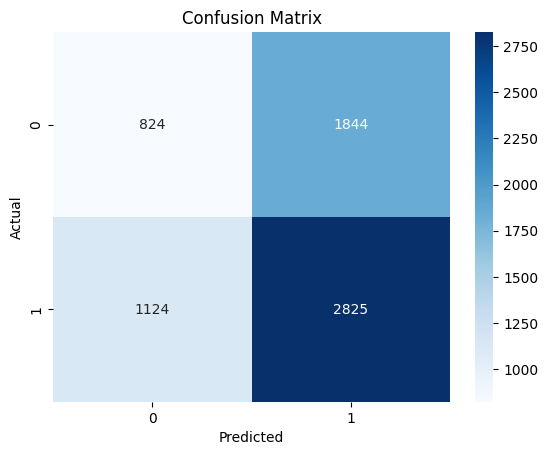

In [19]:
# Evaluate the model
print('Best Neural Network classification report:')
print(classification_report(y_final_true, list(y_pred_true)))

# Confusion matrix
conf_matrix_nn = confusion_matrix(y_final_true, list(y_pred_true))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()